In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from synthpop import Synthpop
import matplotlib.pyplot as plt
from helper_functions import *
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

### Load data and data preperation

In [2]:
admissions_df = pd.read_csv('../datasets/data/bar_pass_prediction.csv', index_col=False)
print(admissions_df.shape)
print(admissions_df.columns)
display(admissions_df.head())

(22407, 39)
Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')


,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


In [3]:
# Remove all rows with missing values
#admissions_df = admissions_df.dropna() don't drop rows with missing values.
#Missing values are important information, and py-synthpop should be able to deal with it.
print(admissions_df.shape)
print(admissions_df.isnull().sum())

(22407, 39)
decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr                      40
fulltime                     34
fam_inc                     289
age                          89
gender                        5
parttime                     34
male                          5
race1                        16
race2                        16
Dropout                       0
other                         0
asian                         0
black                         0
hisp                          0
pass_bar                    

In [4]:
# subset of data
df = admissions_df[['sex', 'race1', 'ugpa', 'bar']]

##### Change sex data manually to categorical 

In [5]:
# change sex data type to categorical
df['sex'] = df['sex'].map({1: 'male', 2: 'female',}, na_action='ignore')
print(df.isnull().sum())

sex       5
race1    16
ugpa      0
bar       0
dtype: int64


**UI text #1**

A subset of the [Law School Admission Bar*](https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage) dataset is used as a demo. Synthetic data will be generated for the following columns: 

- sex: student gender, i.e. 1 (male), 2 (female)
- race1: race, i.e. asian, black, hispanic, white, other
- ugpa: The student's undergraduate GPA, continous variable;
- bar: Ground truth label indicating whether or not the student passed the bar, i.e. passed 1st time, passed 2nd time, failed, non-graduated

The CART method is used to generate the synthetic data. CART generally produces higher quality synthetic datasets, but might not run on datasets with categorical variables with 20+ categories. Use Gaussian Copula in those cases.

_info box:_ The CART (Classification and Regression Trees) method generates synthetic data by learning patterns from real data through decision trees that splits data into homogeneous groups based on feature values one variable at a time. It uses these groups to generate plausible synthetic values for that variable.

*The original paper can be found [here](https://files.eric.ed.gov/fulltext/ED469370.pdf).

### 0. Preview of real data

In [6]:
# demo dataset
df.head()

,sex,race1,ugpa,bar
0,male,white,3.5,a Passed 1st time
1,male,white,3.5,a Passed 1st time
2,female,white,3.5,a Passed 1st time
3,female,white,3.5,a Passed 1st time
4,female,white,3.5,a Passed 1st time


In [7]:
print(df.isnull().sum())

sex       5
race1    16
ugpa      0
bar       0
dtype: int64


### 1. Data types detection

In [8]:
# get the data types of columns using helper function
# can this now be retrieved from Synthpop.fit(df)? @ruben Adjustments to be made for dealing with NaN values
dtypes_dict = data_type(df)
dtypes_dict

{'sex': 'category', 'race1': 'category', 'ugpa': 'float', 'bar': 'category'}

In [9]:
# work around to get method working
df = df.dropna()
print(df.isnull().sum())

sex      0
race1    0
ugpa     0
bar      0
dtype: int64


**UI text #2**

If the detected data types are incorrect, please change this locally in the source dataset before attaching it to the app.

#### 1.2 Create combined dataframe with placeholders for synthetic data

In [10]:
# Initialize Synthpop object with method 'cart'
spop = Synthpop(method='cart')
print(df.isnull().sum())
for (k,v) in dtypes_dict.items():
    if v == 'category':
        df = df.astype({k:v})
# Fit the Synthpop model
spop.fit(df, dtypes=dtypes_dict)

sex      0
race1    0
ugpa     0
bar      0
dtype: int64
True2
True2
          sex  race1  ugpa                bar
0        male  white   3.5  a Passed 1st time
1        male  white   3.5  a Passed 1st time
2      female  white   3.5  a Passed 1st time
3      female  white   3.5  a Passed 1st time
4      female  white   3.5  a Passed 1st time
...       ...    ...   ...                ...
22402  female  black   1.8           c Failed
22403  female  black   1.8           c Failed
22404  female  black   1.8  a Passed 1st time
22405  female  white   1.5  a Passed 1st time
22406  female  white   1.6  a Passed 1st time

[22387 rows x 4 columns]
train_sex
train_race1
train_ugpa
train_bar


In [11]:
# Generate synthetic data
n_synth_data = df.shape[0]
print(f"number of rows = {n_synth_data}")
synth_df = spop.generate(n_synth_data)
print("null values is original data:\n", df.isnull().sum())
print("null values is synthetic data:\n", synth_df.isnull().sum())

number of rows = 22387
generate_sex
generate_race1
generate_ugpa
generate_bar
null values is original data:
 sex      0
race1    0
ugpa     0
bar      0
dtype: int64
null values is synthetic data:
 sex      0
race1    0
ugpa     0
bar      0
dtype: int64


### 2. Evaluation of generated data

In [12]:
# combine original data and decoded synthetic data in dataframe
combined_data = pd.concat((df.assign(realOrSynthetic='real'), synth_df.assign(realOrSynthetic='synthetic')), keys=['real','synthetic'], names=['Data'])

#### Univariate distributions

**UI text #3**

{n_synth_data} synthetic data points are generated using CART. The figures below display the differences in value frequency for each variable. The synthetic data is of high quality when all bars are of equal height.

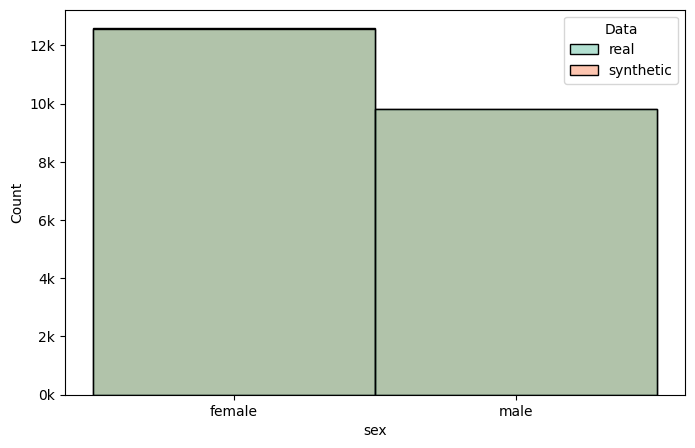

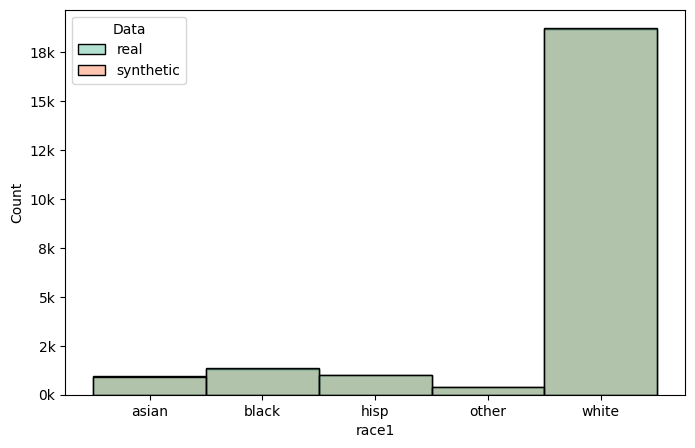

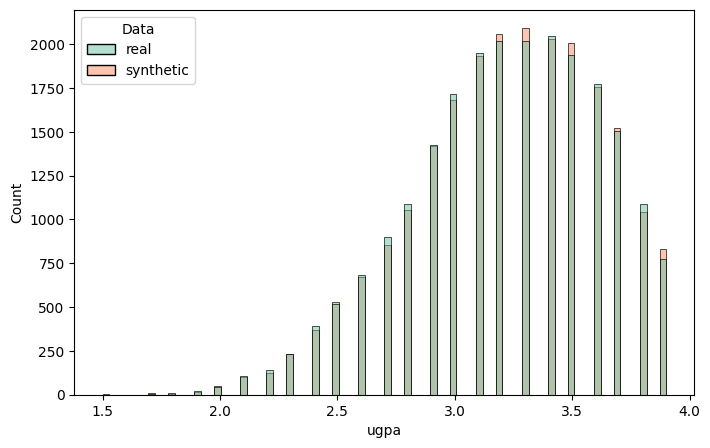

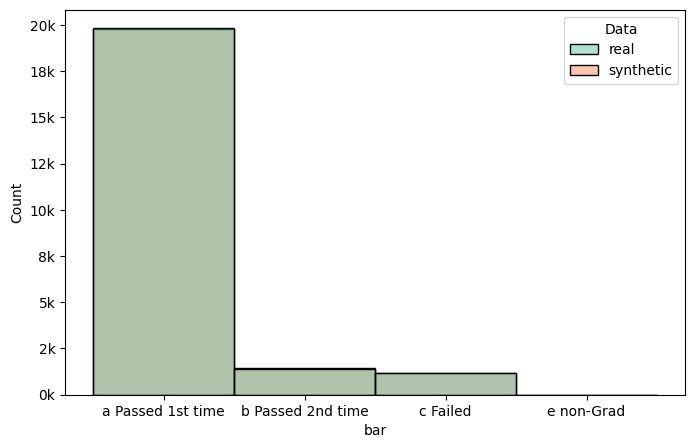

In [13]:
# plot univariate histograms using helper function
univariate_hist(combined_data,dtypes_dict,Comparison=True)

#### Bivariate distributions

**UI text #4**

The figures below display the differences in value frequency for a combination of variables. For comparing two categorical variables, bar charts are plotted. For comparing a numerical and a categorical variables, a so called [violin plot](https://en.wikipedia.org/wiki/Violin_plot) is shown. For comparing two numercial variables, a [LOESS plot](https://en.wikipedia.org/wiki/Local_regression) is created. For all plots holds: the synthetic data is of high quality when the shape of the distributions in the synthetic data equal the distributions in the real data.

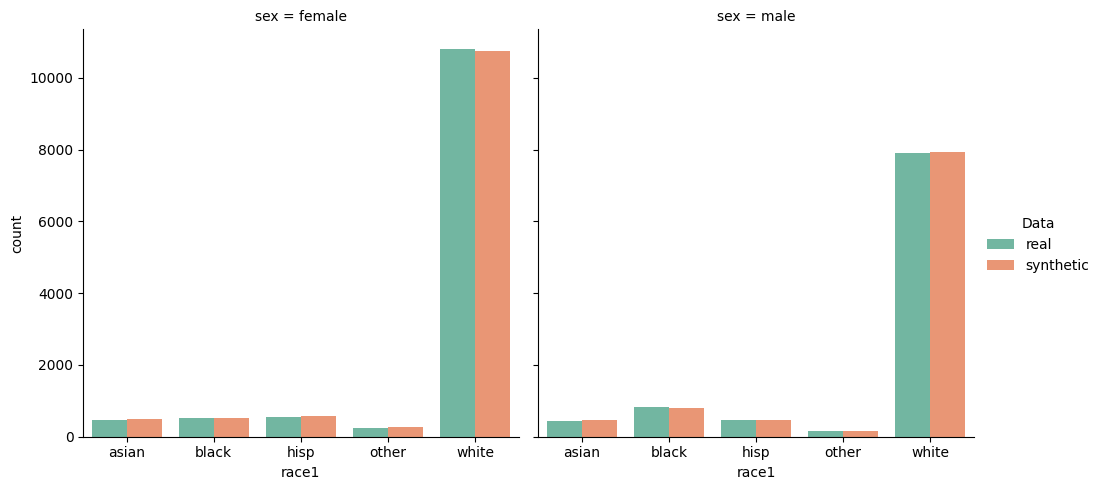

In [14]:
column_name1 = 'sex'
column_name2 = 'race1'

sns.catplot(x=column_name2,
    hue="Data",
    col=column_name1,
    data=combined_data,
    kind="count",
    palette='Set2')

<Figure size 800x500 with 0 Axes>

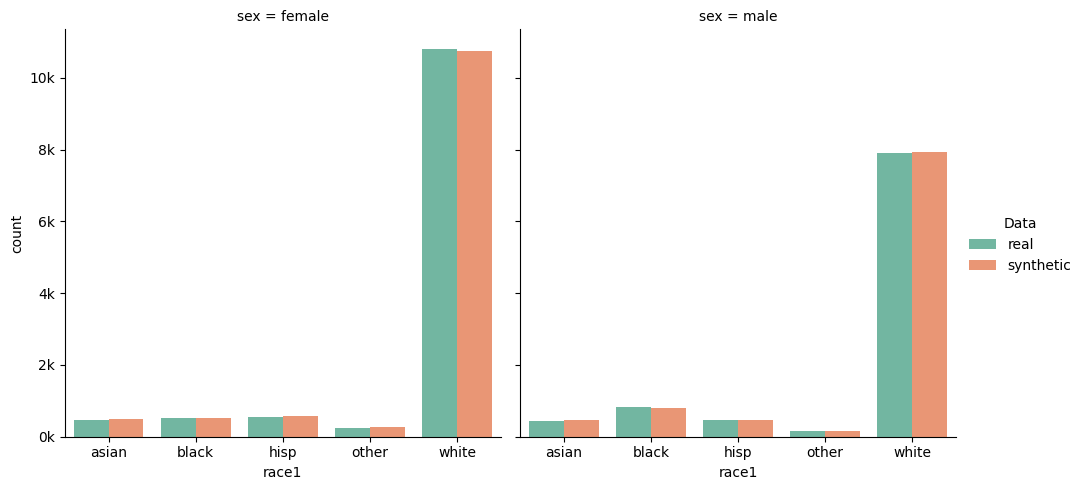

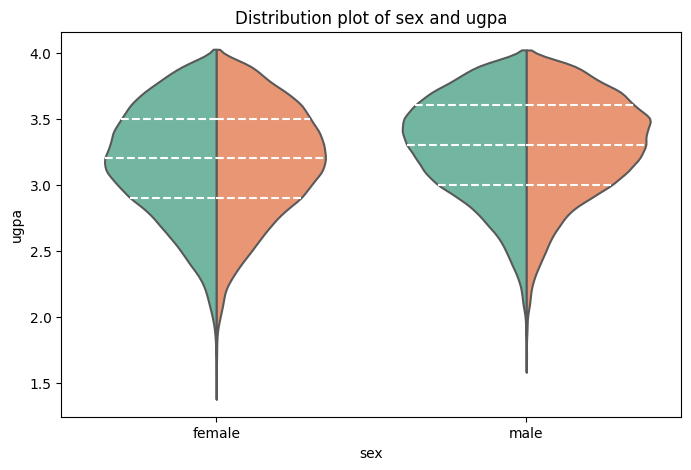

<Figure size 800x500 with 0 Axes>

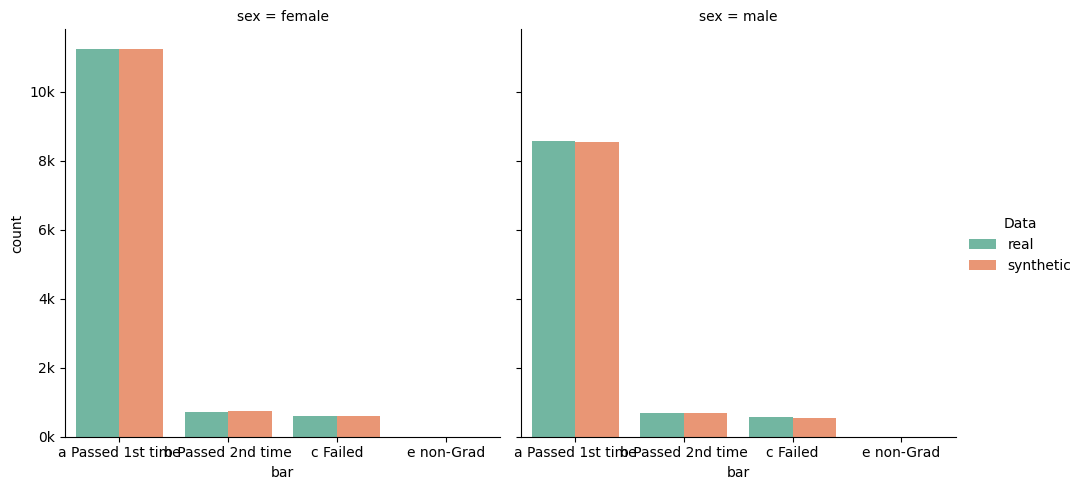

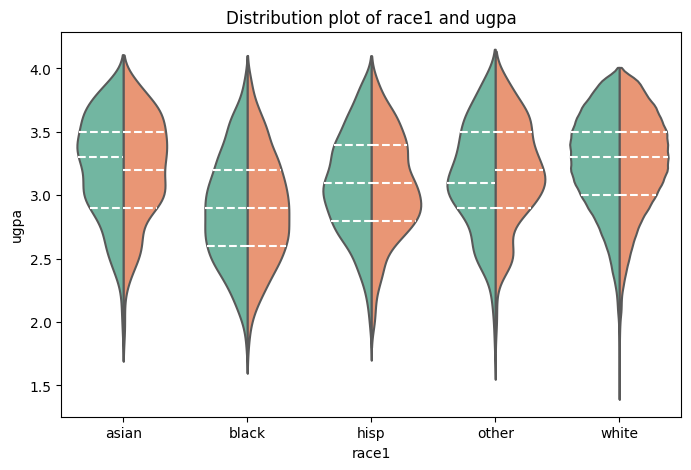

<Figure size 800x500 with 0 Axes>

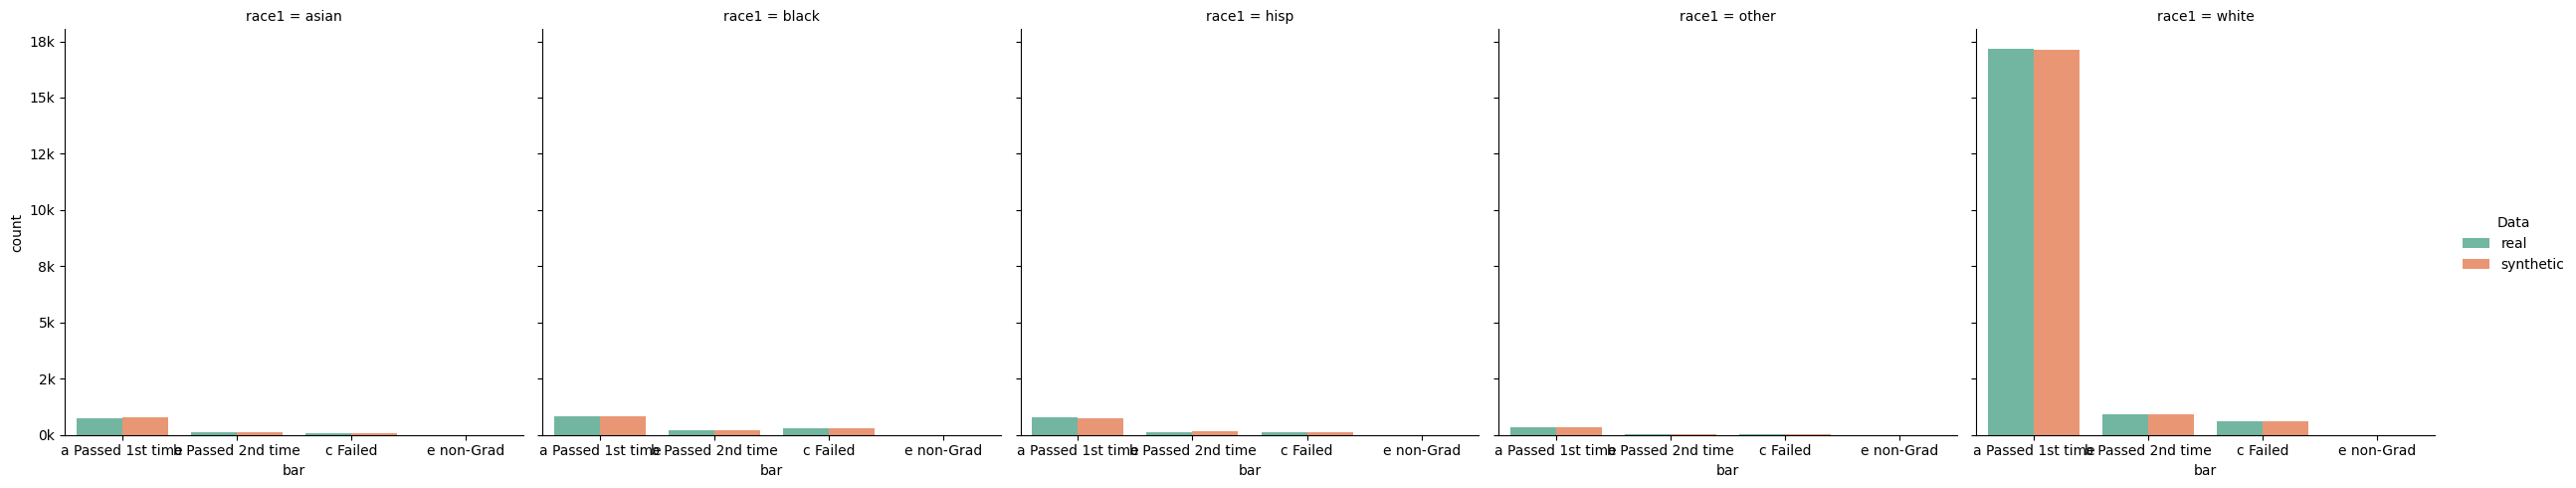

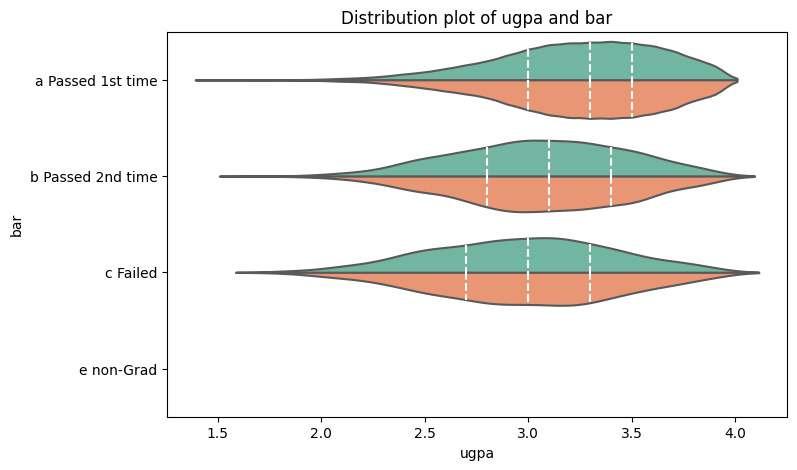

In [15]:
bivariate_plot(df, combined_data, dtypes_dict, Comparison=True)

#### Correlation matrix

**UI text #5**

The matrix below illustrates the differences in pairwise correlations between variables in the original and synthetic data. Green cells signify that the pairwise correlation was accurately captured, with 0 representing the best possible score. Red cells indicate poor capture of the pairwise correlation.

In [16]:
# Convert categorical variables to numerical values
df_encoded = df.copy()
df_encoded['sex'] = df_encoded['sex'].cat.codes
df_encoded['race1'] = df_encoded['race1'].cat.codes
df_encoded['bar'] = df_encoded['bar'].cat.codes

synth_df_encoded = synth_df.copy()
synth_df_encoded['sex'] = synth_df_encoded['sex'].cat.codes
synth_df_encoded['race1'] = synth_df_encoded['race1'].cat.codes
synth_df_encoded['bar'] = synth_df_encoded['bar'].cat.codes


Text(0.5, 1.05, 'Absolute difference in correlation matrix, i.e., |real data - synthetic data|')

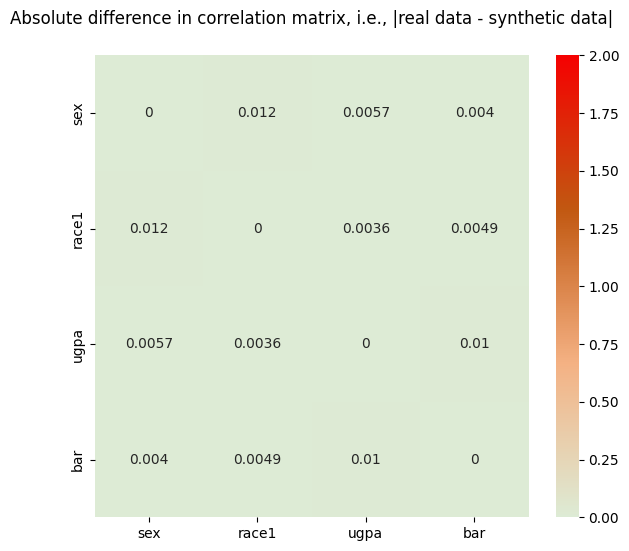

In [17]:
# Plot difference in correlation matrix between attached data and synthetic data
plt.figure(figsize=(7, 6))

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#ddebd5', '#f4b183', '#c15811', '#f50101'])

# Plot correlation matrix for real_data
sns.heatmap(np.abs(df_encoded.corr() - synth_df_encoded.corr()), annot=True, cmap=cmap, vmin=0, vmax=2)
plt.title('Absolute difference in correlation matrix, i.e., |real data - synthetic data|', y=1.05)

#### 2.4 Diagnostic results

**UI text #6**

The diagnostic results reports rates the quality and structure of the synthetic data. 

In [18]:
class Report:
    """This class creates a report for synthetic data.
    """

    def __init__(self):
        self.data_structure_score = None
    

In [19]:
def DataStructure(real_data, synthetic_data):
        """This metric computes whether the names and data types of each column are the same in the real and synthetic data.

        Args:
            real_data (pandas.DataFrame):
                The real data.
            synthetic_data (pandas.DataFrame):
                The synthetic data.
        """
        real_columns_dtypes = set(zip(real_data.columns, map(str, real_data.dtypes)))
        synthetic_columns_dtypes = set(zip(synthetic_data.columns, map(str, synthetic_data.dtypes)))

        intersection = real_columns_dtypes & synthetic_columns_dtypes
        union = real_columns_dtypes | synthetic_columns_dtypes
        score = len(intersection) / len(union)

        return(f'Data structure: {score * 100:.1f}%')


# def MissingValue(real_data, synthetic_data):
#         """Compare the missing value similarity of two continuous columns.

#         Args:
#             real_data (Union[numpy.ndarray, pandas.Series]):
#                 The values from the real dataset.
#             synthetic_data (Union[numpy.ndarray, pandas.Series]):
#                 The values from the synthetic dataset.

#         Returns:
#             dict:
#                 A mapping of the missing value similarity results.
#         """

#         real_data_value = real_data.isna().sum() / len(real_data)
#         synthetic_data_value = synthetic_data.isna().sum() / len(synthetic_data)

#         return {
#             'score': 1 - abs(real_data_value - synthetic_data_value),
#             'real': real_data_value,
#             'synthetic': synthetic_data_value,
#         }

import pandas as pd
from scipy.stats import wasserstein_distance, entropy
from itertools import combinations

def ColumnShape(real_data, synthetic_data, statistic='mean'):
    """Compare the breakdown of statistic similarity of two continuous columns.

    Args:
        real_data (Union[numpy.ndarray, pandas.Series]):
            The values from the real dataset.
        synthetic_data (Union[numpy.ndarray, pandas.Series]):
            The values from the synthetic dataset.

    Returns:
        dict:
            A dict containing the score, and the real and synthetic metric values.
    """
    results = []

    for col1, col2 in combinations(df.columns, 2):
        if pd.api.types.is_numeric_dtype(df[col1]) and pd.api.types.is_numeric_dtype(df[col2]):
            # Numerical columns: Use Wasserstein distance (Earth Mover's Distance)
            similarity = 1 / (1 + wasserstein_distance(df[col1].dropna(), df[col2].dropna()))
            metric = 'Wasserstein Distance'
        
        elif pd.api.types.is_categorical_dtype(df[col1]) or pd.api.types.is_object_dtype(df[col1]) and \
             pd.api.types.is_categorical_dtype(df[col2]) or pd.api.types.is_object_dtype(df[col2]):
            # Categorical columns: Use Jensen-Shannon Divergence for probability distributions
            freq1 = df[col1].value_counts(normalize=True)
            freq2 = df[col2].value_counts(normalize=True)
            # Align indices (categories) for both columns
            all_categories = freq1.index.union(freq2.index)
            freq1 = freq1.reindex(all_categories, fill_value=0)
            freq2 = freq2.reindex(all_categories, fill_value=0)
            similarity = 1 - entropy(freq1, freq2)  # Similarity based on entropy
            metric = 'Entropy-Based Similarity'
        else:
            similarity = None
            metric = 'Incompatible Types'

        results.append({'Column 1': col1, 'Column 2': col2, 'Metric': metric, 'Similarity': similarity})
    
    return pd.DataFrame(results)

**UI text #7**

The data structure score computes whether the names and data types of each column are the same in the real and synthetic data.

💯 The score for data structure should be 100% or very close to it.

In [20]:
DataStructure(df, synth_df)

'Data structure: 100.0%'

**UI text #8**

The column shape score computes the statistical similarity between the real and synthetic data for single columns of data. This is often called the _marginal distribution_ of each column.

In [22]:
ColumnShape(df, synth_df)

,Column 1,Column 2,Metric,Similarity
0,sex,race1,Entropy-Based Similarity,-inf
1,sex,ugpa,Entropy-Based Similarity,-inf
2,sex,bar,Entropy-Based Similarity,-inf
3,race1,ugpa,Entropy-Based Similarity,-inf
4,race1,bar,Entropy-Based Similarity,-inf
5,ugpa,bar,Incompatible Types,NaN


**UI text #9**

The column shape checks how close the marginal distributions for the real and synthetic data are. column pair trendschecks the statistical similarity between pairs of columns in the real and synthetic data.

Scores:
- Data structure:
- Column shapes:
- Column pair trends:
- KS complement: 
- TS complement:
- Column pair trends:
- Privacy:

Overall score (green, yellow, red)



### 3. Output data

In [23]:
# preview of synthetic data
synth_df.head()

,sex,race1,ugpa,bar
0,male,white,3.4,a Passed 1st time
1,female,white,2.8,a Passed 1st time
2,male,white,2.9,a Passed 1st time
3,female,white,2.7,a Passed 1st time
4,male,white,3.3,a Passed 1st time


### 4. More information

**UI text #7**

Do you want to learn more about synthetic data?
- Source code on Github:
    - [python-synthpop](https://github.com/NGO-Algorithm-Audit/python-synthpop)
    - [local-first web app](https://github.com/NGO-Algorithm-Audit/local-first-web-tool/tree/main) 
- [Synthetic Data: what, why and how?](https://royalsociety.org/-/media/policy/projects/privacy-enhancing-technologies/Synthetic_Data_Survey-24.pdf)
- [Knowledge Network Synthetic Data](https://online.rijksinnovatiecommunity.nl/groups/399-kennisnetwerk-synthetischedata/welcome) (for Dutch public organizations)
- [Synthetic data portal of Dutch Executive Agency for Education](https://duo.nl/open_onderwijsdata/footer/synthetische-data.jsp) (DUO)
- [CART: synthpop resources](https://synthpop.org.uk/resources.html)
- [Gaussian Copula - Synthetic Data Vault](https://docs.sdv.dev/sdv)
